In [36]:
# Прогнозирование забойного давления (BHP) с использованием стекинга

Этот Jupyter Notebook реализует модель стекинга для прогнозирования забойного давления (BHP) на основе данных о скважинах.
Используются базовые модели (RandomForest, GradientBoosting, DecisionTree) и мета-модель (LinearRegression).
Также выполняется визуализация важности признаков и прогнозов.

## Зачем используется стекинг?

На этапе анализа данных было установлено, что отдельные модели (RandomForest, GradientBoosting, DecisionTree) демонстрируют хорошие результаты в прогнозировании исторических значений забойного давления (BHP),
но каждая из них лучше справляется с определенными аспектами данных. Например, RandomForest эффективно улавливает нелинейные зависимости, GradientBoosting хорошо работает с последовательным улучшением предсказаний,
а DecisionTree обеспечивает интерпретируемость. Чтобы объединить сильные стороны этих моделей и повысить общую точность прогнозов, был применен подход стекинга.
Стекинг позволяет комбинировать предсказания базовых моделей с помощью мета-модели (LinearRegression), которая обучается на их выходах, оптимизируя итоговый результат.

## Зависимости
- Python 3.8+
- pandas
- numpy
- scikit-learn
- seaborn
- matplotlib
- plotly

## Описание данных
- **teach_data.csv**: Обучающий набор данных с колонками:
  - `Well Name`: Название скважины (строка)
  - `Last`: Дата в формате DD.MM.YY
  - `BHP`: Забойное давление (целевая переменная, число)
  - `Choke`, `WHP`, `Gas`, ...: Признаки (числа)
- **forecast.csv**: Данные для прогнозирования с аналогичной структурой.

## Установка
```bash
pip install pandas numpy scikit-learn seaborn matplotlib plotly

SyntaxError: invalid syntax (17705196.py, line 3)

In [44]:
#Импорт библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display

In [45]:
## 2. Загрузка и предобработка данных
# Загрузка обучающих данных
dfs = pd.read_csv('teach_data.csv', delimiter=';')

# Удаление ненужных столбцов
dfs = dfs.drop(['Well Name', 'Last'], axis=1)

# Удаление строк с пропусками и нулевыми значениями
dfs = dfs.dropna()
dfs = dfs[dfs['Choke'] != 0]
dfs = dfs[dfs['BHP'] != 0]
dfs['BHP'] = pd.to_numeric(dfs['BHP'], errors='coerce')

# Фильтрация выбросов по IQR
Q1 = dfs['BHP'].quantile(0.25)
Q3 = dfs['BHP'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.55 * IQR
upper_bound = Q3 + 1.55 * IQR
dfs = dfs[(dfs['BHP'] >= lower_bound) & (dfs['BHP'] <= upper_bound)]

# Сброс индексов
dfs.reset_index(drop=True, inplace=True)

# Разделение на признаки и целевую переменную
X = dfs.drop('BHP', axis=1)
y = dfs['BHP']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

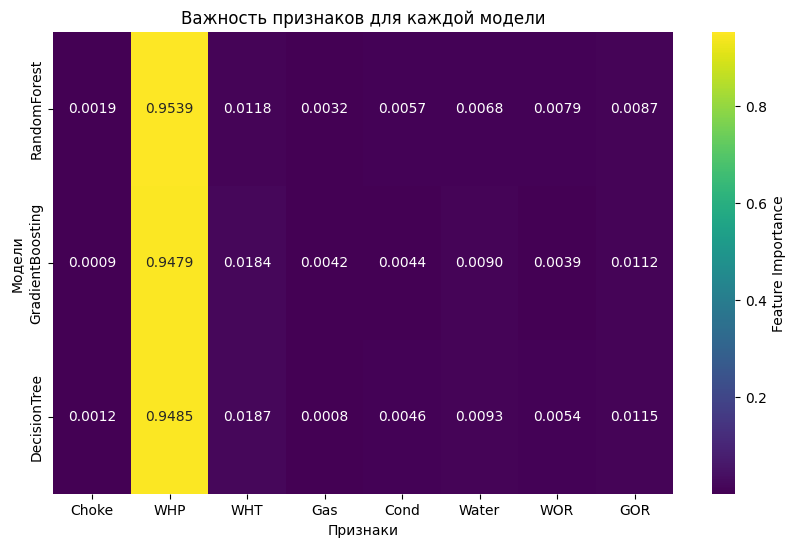

In [46]:
## 3. Обучение базовых моделей и анализ важности признаков
# Определение базовых моделей
base_models = [
    ('RandomForest', RandomForestRegressor(n_estimators=42, random_state=21)),
    ('GradientBoosting', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('DecisionTree', DecisionTreeRegressor(random_state=42))
]

# Обучение базовых моделей и сбор важности признаков
feature_importances = []
model_names = []

for name, model in base_models:
    model.fit(X_train, y_train)
    feature_importances.append(model.feature_importances_)
    model_names.append(name)

# Создание DataFrame для важности признаков
feature_importance_df = pd.DataFrame(
    feature_importances,
    index=model_names,
    columns=X_train.columns
)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
sns.heatmap(feature_importance_df, annot=True, cmap='viridis', fmt='.4f', cbar_kws={'label': 'Feature Importance'})
plt.title('Важность признаков для каждой модели')
plt.xlabel('Признаки')
plt.ylabel('Модели')
plt.show()

In [47]:
## 4. Обучение мета-модели (стекинг)
# Кросс-валидация для получения мета-признаков
kf = KFold(n_splits=5)
meta_features = np.zeros((X_train.shape[0], len(base_models)))

for i, (_, model) in enumerate(base_models):
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        model.fit(X_train_fold, y_train_fold)
        meta_features[val_index, i] = model.predict(X_val_fold)

# Обучение мета-модели
meta_model = LinearRegression()
meta_model.fit(meta_features, y_train)

# Предсказания на тестовой выборке
meta_test_features = np.column_stack([model.predict(X_test) for _, model in base_models])
final_predictions = meta_model.predict(meta_test_features)

# Оценка модели
mse = mean_squared_error(y_test, final_predictions)
r2 = r2_score(y_test, final_predictions)

print('\nМетрики модели:')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')


Метрики модели:
Mean Squared Error: 80.94
R-squared: 0.99


In [42]:
## 5. Прогнозирование на новых данных
# Загрузка данных для прогнозирования
new_data = pd.read_csv('forecast.csv', delimiter=';')
new_data = new_data.dropna()
data_with_date = new_data
new_data = new_data.drop(['Well Name', 'Last', 'BHP'], axis=1)

# Прогнозирование
meta_new_features = np.column_stack([model.predict(new_data) for _, model in base_models])
predictions = meta_model.predict(meta_new_features)

# Формирование таблицы прогнозов
forecast_table = pd.DataFrame({
    'Well Name': data_with_date['Well Name'],
    'Date': data_with_date['Last'],
    'Predicted BHP': np.round(predictions, 1)
})
forecast_table['Date'] = pd.to_datetime(forecast_table['Date'], format='%d.%m.%y', errors='coerce')
forecast_table = forecast_table.sort_values('Date')

# Вывод таблицы прогнозов
print('-' * 100)
print("Прогнозы BHP:")
display(forecast_table)
print('-' * 100)

----------------------------------------------------------------------------------------------------
Прогнозы BHP:


,Well Name,Date,Predicted BHP
0,Field2-1W,2025-01-01,286.3
1,Field2-1W,2025-02-09,284.1
2,Field2-1W,2025-02-23,284.2
3,Field2-1W,2025-03-14,283.4
4,Field2-1W,2025-03-16,283.1
5,Field2-1W,2025-04-01,281.1
6,Field2-1W,2025-04-17,275.8
7,Field2-1W,2025-04-21,275.6
8,Field2-1W,2025-04-24,283.3


----------------------------------------------------------------------------------------------------


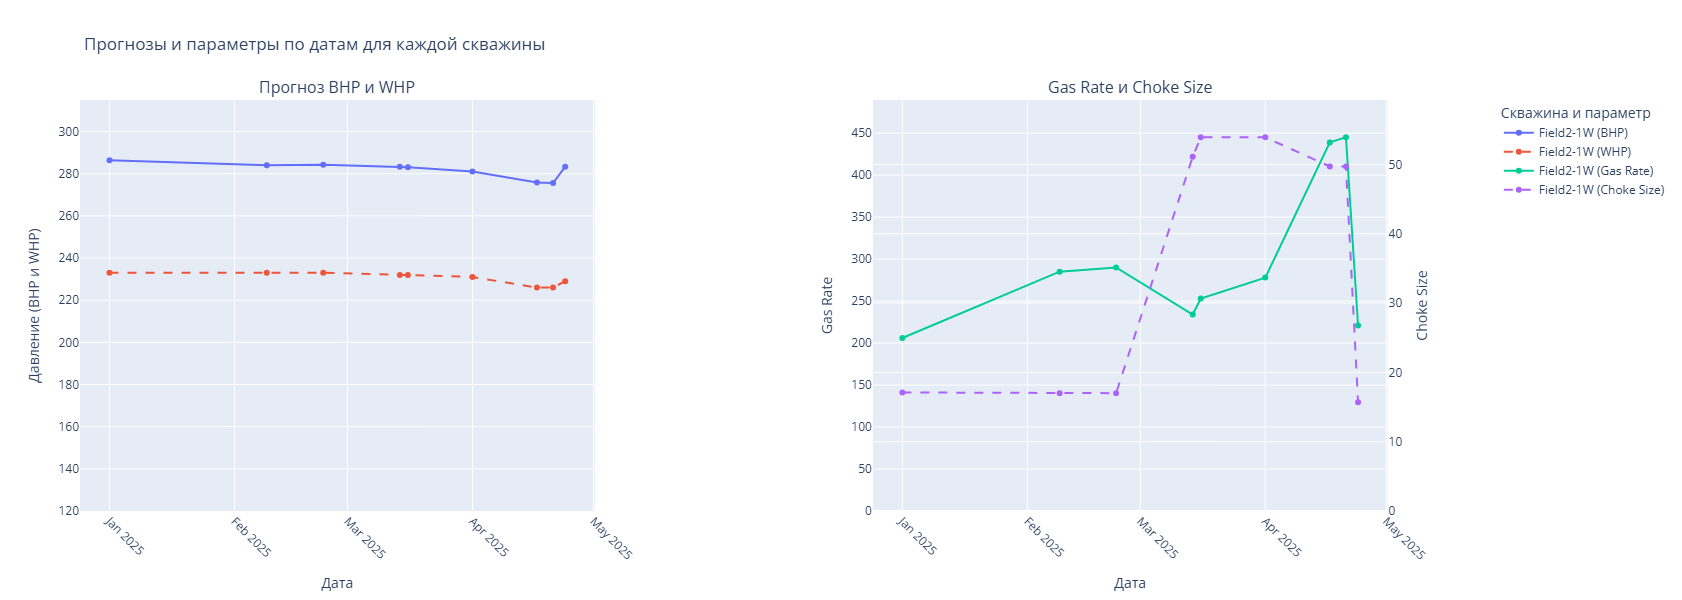

In [48]:
## 6. Визуализация прогнозов и параметров
# Подготовка данных для графика
plot_data = pd.DataFrame({
    'Well_Name': data_with_date['Well Name'],
    'Date': data_with_date['Last'],
    'Predicted_BHP': predictions,
    'WHP': data_with_date['WHP'],
    'Gas_Rate': data_with_date['Gas'],
    'Choke_Size': data_with_date['Choke']
})

# Преобразование столбца Date в формат datetime
plot_data['Date'] = pd.to_datetime(plot_data['Date'], format='%d.%m.%y', errors='coerce')

# Сортировка данных по дате
plot_data = plot_data.sort_values('Date')

# Создание подграфиков
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Прогноз BHP и WHP', 'Gas Rate и Choke Size'),
    shared_xaxes=True,
    column_widths=[0.5, 0.5],
    specs=[[{'secondary_y': False}, {'secondary_y': True}]]
)

# Первый подграфик: Predicted_BHP и WHP
for well in plot_data['Well_Name'].unique():
    well_data = plot_data[plot_data['Well_Name'] == well]
    # Линии для Predicted_BHP
    fig.add_trace(
        go.Scatter(
            x=well_data['Date'],
            y=well_data['Predicted_BHP'],
            mode='lines+markers',
            name=f'{well} (BHP)',
            line=dict(width=2),
            marker=dict(size=6)
        ),
        row=1, col=1
    )
    # Линии для WHP (пунктирные)
    fig.add_trace(
        go.Scatter(
            x=well_data['Date'],
            y=well_data['WHP'],
            mode='lines+markers',
            name=f'{well} (WHP)',
            line=dict(width=2, dash='dash'),
            marker=dict(size=6)
        ),
        row=1, col=1
    )

# Второй подграфик: Gas Rate (основная ось) и Choke Size (вторичная ось)
for well in plot_data['Well_Name'].unique():
    well_data = plot_data[plot_data['Well_Name'] == well]
    # Линии для Gas Rate
    fig.add_trace(
        go.Scatter(
            x=well_data['Date'],
            y=well_data['Gas_Rate'],
            mode='lines+markers',
            name=f'{well} (Gas Rate)',
            line=dict(width=2),
            marker=dict(size=6)
        ),
        row=1, col=2,
        secondary_y=False
    )
    # Линии для Choke Size (пунктирные)
    fig.add_trace(
        go.Scatter(
            x=well_data['Date'],
            y=well_data['Choke_Size'],
            mode='lines+markers',
            name=f'{well} (Choke Size)',
            line=dict(width=2, dash='dash'),
            marker=dict(size=6)
        ),
        row=1, col=2,
        secondary_y=True
    )

# Настройка внешнего вида графика
y_min = 120  # Минимальное значение оси Y для первого подграфика
y_max = max(max(plot_data['Predicted_BHP']), max(plot_data['WHP'])) * 1.1  # Максимум с запасом
fig.update_layout(
    title_text='Прогнозы и параметры по датам для каждой скважины',
    width=1650,
    height=600,
    showlegend=True,
    legend_title='Скважина и параметр'
)

# Настройка осей
fig.update_xaxes(title_text='Дата', tickangle=45, row=1, col=1)
fig.update_yaxes(title_text='Давление (BHP и WHP)', range=[y_min, y_max], row=1, col=1)
fig.update_xaxes(title_text='Дата', tickangle=45, row=1, col=2)
fig.update_yaxes(title_text='Gas Rate', range=[0, max(plot_data['Gas_Rate']) * 1.1], row=1, col=2, secondary_y=False)
fig.update_yaxes(title_text='Choke Size', range=[0, max(plot_data['Choke_Size']) * 1.1], row=1, col=2, secondary_y=True)

# Отображение графика
fig.show()